In [ ]:
# Experiment 3: Fine-tuning Naija-BERT on English Sentiment Dataset (GPU Version)
# This notebook implements the training procedure for the third experiment in our cross-lingual sentiment analysis project

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
import os
import random
import re
!pip install emoji
import emoji
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ## 1. Data Preparation

# Function to clean and normalize text
def clean_text(text, is_pidgin=False):
    """
    Clean and normalize text data

    Args:
        text (str): Input text
        is_pidgin (bool): Whether the text is Nigerian Pidgin

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', ' [USER] ', text)

    # Handle hashtags - keep the text but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)

    # Convert emojis to text (alternatively, you can remove them)
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_]+:', ' [EMOJI] ', text)  # replace with token or remove

    # Remove special characters but keep apostrophes (important for contractions)
    text = re.sub(r'[^a-zA-Z0-9\'\s]', ' ', text)

    # Normalize apostrophes
    text = text.replace("'", "'")

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # For Pidgin-specific normalization
    if is_pidgin:
        # Define common Pidgin expressions to preserve
        pidgin_normalizations = {
            # Common variations
            " de ": " dey ",
            " sey ": " say ",
            " dem ": " them ",
            " una ": " you ",
            " dis ": " this ",
            " dat ": " that ",
            " e ": " e ",  # (it/him/her)
            " im ": " him ",
            " una ": " you all ",
            " make ": " make ",  # (let/allow)
            " no ": " no ",  # (negation)
            " o ": " o ",  # (emphasis)
            " go ": " go ",  # (will/future tense)
            " don ": " don ",  # (has/have done)
            " fit ": " fit ",  # (can/able to)
            " wan ": " want ",  # (want)
            " sabi ": " sabi ",  # (know)
            " taya ": " taya ",  # (tired)
            " chop ": " chop ",  # (eat)
            " yarn ": " yarn ",  # (talk/gist)
            " pikin ": " pikin ",  # (child)
            " waka ": " waka ",  # (walk/travel)
            " shuo ": " shuo ",  # (exclamation)
            # Common expressions (keep intact)
            "abeg": "abeg",  # please
            "wetin": "wetin",  # what
            "na ": "na ",  # is/it is
            "abi": "abi",  # right?/isn't it?
            "shey": "shey",  # is it that
            "sha": "sha",  # anyway/though
            "wahala": "wahala",  # trouble
            "japa": "japa",  # run away/leave
            "gats": "gats",  # must/have to
            "chook": "chook",  # pierce/stab
            "bros": "bros",  # brother/friend
            "mumu": "mumu",  # foolish/silly
            "baff": "baff",  # bath
            "sef": "sef",  # even/too
            "komot": "komot",  # remove/come out
            "troway": "troway",  # throw away
            "kuku": "kuku",  # might as well
            "jeje": "jeje",  # gently/softly
            "ginger": "ginger",  # motivate/cheer
            "yarn": "yarn",  # talk/gist
            "palava": "palava",  # problem/issue
            "bod": "bod",  # bold/audacity
            "fess": "fess",  # speak boldly
            "gbam": "gbam",  # exactly/spot on
            "ogbonge": "ogbonge",  # real/genuine
            "wuruwuru": "wuruwuru",  # shady/dishonest
            "k-leg": "k-leg",  # suspicious
            "baff": "bath",  # bath
            "maga": "maga",  # a gullible person
            "buruku": "buruku",  # bad/evil
            "shakara": "shakara",  # showing off
            "akara": "akara",  # bean cake (sometimes used metaphorically)
            "gbosa": "gbosa",  # loud noise/shout
            "soro": "soro",  # speak (often "soro soke" - speak up)
            "gbera": "gbera",  # rise/get up
            "tor": "tor",  # though/despite
            "gbese": "gbese",  # debt
            "yawa": "yawa",  # trouble/problem
            "gbas": "gbas",  # sound of slap/hit
            "kilode": "kilode",  # why?/what's happening?
            "yeye": "yeye",  # nonsense/worthless
            "how far?": "how far?",  # A greeting meaning "how are you?"
            "oya": "oya",  # hurry up
            "commot for road": "commot for road",  # leave/get out of the way
            "as e were": "as e were",  # as usual/as it was
            "mind your business": "mind your business",  # stay out of others' affairs
            "see finish": "see finish",  # see something through to the end
            "wahala for who no sabi": "wahala for who no sabi",  # trouble for those who don't know
            "e choke": "e choke",  # it's shocking/surprising
            "e go be": "e go be",  # it will happen
            "e no concern me": "e no concern me",  # it doesn't concern me
            "e no dey": "e no dey",  # it doesn't exist/is absent
            "e tire me": "e tire me",  # it tires me

        }

        for old, new in pidgin_normalizations.items():
            text = text.replace(old, new)

    return text.strip()

In [ ]:
# Custom dataset class
class SentimentDataset(Dataset):
    """PyTorch dataset for sentiment analysis"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove the batch dimension which tokenizer adds by default
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label)

        return encoding


In [ ]:
# Load and prepare datasets
print("Loading datasets...")

# Load English dataset as the primary training set for Experiment 3
english_df = pd.read_csv('English_dataset.csv')
print(f"English dataset shape: {english_df.shape}")

Loading datasets...
English dataset shape: (10000, 2)


In [ ]:
# Map sentiments to numeric values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
english_df['label'] = english_df['Sentiments'].map(sentiment_map)

# Clean text
english_df['cleaned_text'] = english_df['text'].apply(lambda x: clean_text(x, is_pidgin=False))

In [ ]:
# Check sentiment distribution
sentiment_counts = english_df['Sentiments'].value_counts()
print("\nEnglish sentiment distribution:")
print(sentiment_counts)
print(f"Percentages: {sentiment_counts / len(english_df) * 100}")


English sentiment distribution:
Sentiments
positive    7663
negative    2317
neutral       20
Name: count, dtype: int64
Percentages: Sentiments
positive    76.63
negative    23.17
neutral      0.20
Name: count, dtype: float64


In [ ]:
# Load Pidgin dataset for testing
pidgin_df = pd.read_csv('new_annotated_pidgin.csv')
print(f"\nPidgin dataset shape: {pidgin_df.shape}")
pidgin_df['label'] = pidgin_df['sentiments'].map(sentiment_map)
pidgin_df['cleaned_text'] = pidgin_df['Comments'].apply(lambda x: clean_text(x, is_pidgin=True))


Pidgin dataset shape: (5000, 2)


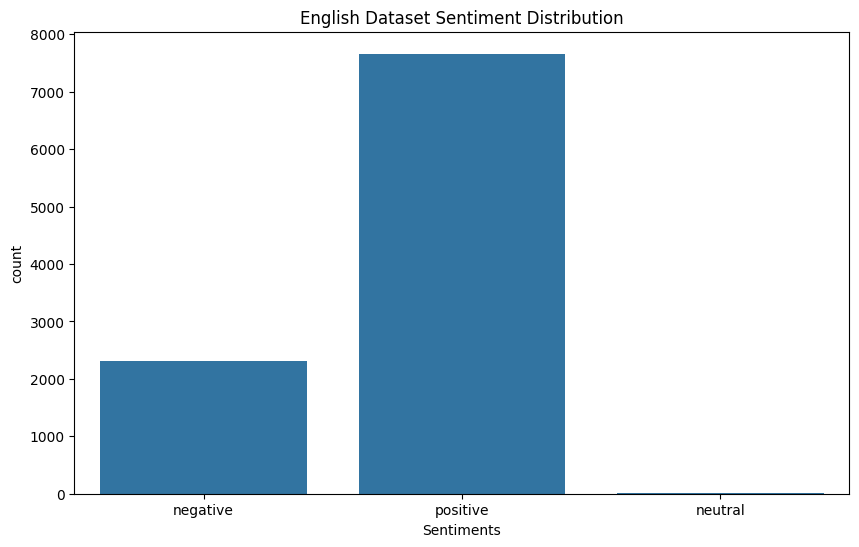

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiments', data=english_df)
plt.title('English Dataset Sentiment Distribution')
plt.show()

In [ ]:
# ## 2. Split Datasets

from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split dataset into train, validation, and test sets with stratification
    """
    # First split: train + validation and test
    train_val, test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['label']
    )

    # Second split: train and validation
    # Adjust validation size relative to train_val
    relative_val_size = val_size / (train_size + val_size)
    train, val = train_test_split(
        train_val, test_size=relative_val_size, random_state=random_state,
        stratify=train_val['label']
    )

    return train, val, test


In [ ]:
# Split English dataset
english_train, english_val, english_test = split_dataset(english_df)

# Display split sizes
print("\nDataset splits:")
print(f"English - Train: {len(english_train)}, Val: {len(english_val)}, Test: {len(english_test)}")


Dataset splits:
English - Train: 7000, Val: 1500, Test: 1500


In [ ]:
# Check class distribution in splits
print("\nTrain distribution:")
print(english_train['Sentiments'].value_counts())
print("\nValidation distribution:")
print(english_val['Sentiments'].value_counts())
print("\nTest distribution:")
print(english_test['Sentiments'].value_counts())


Train distribution:
Sentiments
positive    5364
negative    1622
neutral       14
Name: count, dtype: int64

Validation distribution:
Sentiments
positive    1150
negative     347
neutral        3
Name: count, dtype: int64

Test distribution:
Sentiments
positive    1149
negative     348
neutral        3
Name: count, dtype: int64


In [ ]:
# Sample Pidgin test data
pidgin_test = pidgin_df.sample(750, random_state=42)  # As specified in experiment design
print(f"\nPidgin test set size: {len(pidgin_test)}")
print("Pidgin test distribution:")
print(pidgin_test['sentiments'].value_counts())


Pidgin test set size: 750
Pidgin test distribution:
sentiments
negative    469
neutral     203
positive     78
Name: count, dtype: int64


In [ ]:
# ## 3. Address Class Imbalance

# Check for class imbalance in English data
print("\nChecking for class imbalance in English training data:")
print(english_train['Sentiments'].value_counts(normalize=True) * 100)


Checking for class imbalance in English training data:
Sentiments
positive    76.628571
negative    23.171429
neutral      0.200000
Name: proportion, dtype: float64


In [ ]:
# Compute class weights
def compute_class_weights(labels):
    """Compute class weights inversely proportional to class frequencies"""
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)

    # Ensure we have weights for all 3 classes
    if len(class_weights) < 3:
        pad_length = 3 - len(class_weights)
        class_weights = np.pad(class_weights, (0, pad_length), 'constant')

    return torch.FloatTensor(class_weights)


In [ ]:
# Print actual class counts for verification
print("\nActual class counts in training data:")
print(english_train['label'].value_counts().sort_index())


Actual class counts in training data:
label
0    5364
1    1622
2      14
Name: count, dtype: int64


In [ ]:
class_weights = compute_class_weights(english_train['label'].values)
print("\nComputed class weights for handling imbalance:")
print(f"Positive (0): {class_weights[0]:.4f}")
print(f"Negative (1): {class_weights[1]:.4f}")
print(f"Neutral (2): {class_weights[2]:.4f}")


Computed class weights for handling imbalance:
Positive (0): 0.4350
Negative (1): 1.4386
Neutral (2): 166.6667


In [ ]:
# ## 4. Initialize Tokenizer

# Initialize the Naija-BERT tokenizer
print("Initializing Naija-BERT tokenizer...")
tokenizer = AutoTokenizer.from_pretrained('Davlan/naija-bert-base')

Initializing Naija-BERT tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/589 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/498k [00:00<?, ?B/s]

In [ ]:
# Add special tokens if needed
def enhance_tokenizer(tokenizer):
    """Add any special tokens needed for better handling"""
    # Check if any special tokens need to be added
    additional_tokens = []

    if additional_tokens:
        special_tokens = {'additional_special_tokens': additional_tokens}
        num_added = tokenizer.add_special_tokens(special_tokens)
        print(f"Added {num_added} special tokens to tokenizer")
    else:
        print("No additional special tokens needed for Naija-BERT")

    return tokenizer

tokenizer = enhance_tokenizer(tokenizer)

No additional special tokens needed for Naija-BERT


In [ ]:
# Determine optimal sequence length
def analyze_token_lengths(texts, tokenizer, percentile=95):
    """Analyze token length distribution and determine max length"""
    token_lengths = []
    for text in tqdm(texts, desc="Analyzing token lengths"):
        if isinstance(text, str) and text.strip():
            tokens = tokenizer.tokenize(text)
            token_lengths.append(len(tokens))

    # Calculate statistics
    mean_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    p95 = np.percentile(token_lengths, percentile)
    max_len = np.max(token_lengths)

    # Round up to nearest multiple of 8 for efficiency
    recommended_length = ((int(p95) + 7) // 8) * 8

    print(f"Token length statistics:")
    print(f"Mean: {mean_len:.1f}")
    print(f"Median: {median_len:.1f}")
    print(f"95th percentile: {p95:.1f}")
    print(f"Max: {max_len}")
    print(f"Recommended max_length: {recommended_length}")

    return recommended_length, token_lengths

In [ ]:
# Analyze English and Pidgin token lengths
print("\nAnalyzing English token lengths with Naija-BERT...")
english_sample = english_train['cleaned_text'].sample(500, random_state=42).tolist()
max_length_english, english_lengths = analyze_token_lengths(english_sample, tokenizer)


Analyzing English token lengths with Naija-BERT...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors


Token length statistics:
Mean: 40.0
Median: 24.0
95th percentile: 118.3
Max: 621
Recommended max_length: 120


In [ ]:
print("\nAnalyzing Pidgin token lengths with Naija-BERT...")
pidgin_sample = pidgin_test['cleaned_text'].sample(500, random_state=42).tolist()
max_length_pidgin, pidgin_lengths = analyze_token_lengths(pidgin_sample, tokenizer)



Analyzing Pidgin token lengths with Naija-BERT...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 45.1
Median: 27.0
95th percentile: 149.0
Max: 503
Recommended max_length: 152


In [ ]:
# Use the maximum of both for test data to handle both languages
max_length_test = max(max_length_english, max_length_pidgin)


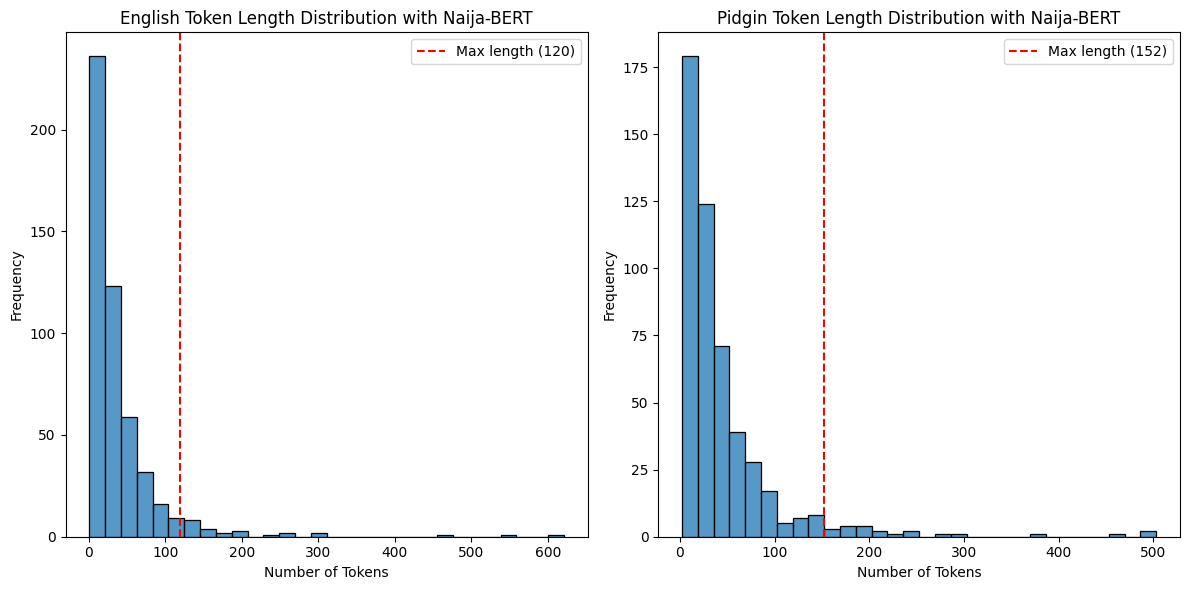

In [ ]:
# Visualize token length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(english_lengths, bins=30)
plt.axvline(x=max_length_english, color='r', linestyle='--', label=f'Max length ({max_length_english})')
plt.title('English Token Length Distribution with Naija-BERT')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(pidgin_lengths, bins=30)
plt.axvline(x=max_length_pidgin, color='r', linestyle='--', label=f'Max length ({max_length_pidgin})')
plt.title('Pidgin Token Length Distribution with Naija-BERT')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ## 5. Create PyTorch Datasets

# Prepare datasets
print("Creating PyTorch datasets...")

# Training dataset
train_dataset = SentimentDataset(
    english_train['cleaned_text'].tolist(),
    english_train['label'].tolist(),
    tokenizer,
    max_length=max_length_english
)

# Validation dataset
val_dataset = SentimentDataset(
    english_val['cleaned_text'].tolist(),
    english_val['label'].tolist(),
    tokenizer,
    max_length=max_length_english
)

# Test datasets (separate for English and Pidgin for cross-lingual evaluation)
english_test_dataset = SentimentDataset(
    english_test['cleaned_text'].tolist(),
    english_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

pidgin_test_dataset = SentimentDataset(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

# Combined test dataset
combined_test_texts = english_test['cleaned_text'].tolist() + pidgin_test['cleaned_text'].tolist()
combined_test_labels = english_test['label'].tolist() + pidgin_test['label'].tolist()

combined_test_dataset = SentimentDataset(
    combined_test_texts,
    combined_test_labels,
    tokenizer,
    max_length=max_length_test
)


Creating PyTorch datasets...


In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"English test dataset size: {len(english_test_dataset)}")
print(f"Pidgin test dataset size: {len(pidgin_test_dataset)}")
print(f"Combined test dataset size: {len(combined_test_dataset)}")


Train dataset size: 7000
Validation dataset size: 1500
English test dataset size: 1500
Pidgin test dataset size: 750
Combined test dataset size: 2250


In [ ]:
# Check example batch
train_batch = next(iter(DataLoader(train_dataset, batch_size=2)))
print("\nExample batch keys:", train_batch.keys())
print(f"Input IDs shape: {train_batch['input_ids'].shape}")
print(f"Attention mask shape: {train_batch['attention_mask'].shape}")
print(f"Labels: {train_batch['labels']}")


Example batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([2, 120])
Attention mask shape: torch.Size([2, 120])
Labels: tensor([0, 0])


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# ## 6. Model Setup and Training

# Define metrics function
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Initialize model
print("\nInitializing Naija-BERT model...")
# First create the standard model
model = AutoModelForSequenceClassification.from_pretrained(
    'Davlan/naija-bert-base',
    num_labels=3,  # positive, negative, neutral
)


Initializing Naija-BERT model...


pytorch_model.bin:   0%|          | 0.00/562M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Davlan/naija-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define weighted trainer that applies class weights during loss computation
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted loss
        if self.class_weights is not None:
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        # Add labels back to inputs for potential use elsewhere
        inputs["labels"] = labels

        return (loss, outputs) if return_outputs else loss

In [ ]:
# Resize token embeddings if tokenizer vocabulary was modified
if len(tokenizer) != model.config.vocab_size:
    model.resize_token_embeddings(len(tokenizer))
    print(f"Resized token embeddings from {model.config.vocab_size} to {len(tokenizer)}")

In [ ]:
# Move model to GPU if available
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(70000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Training arguments
print("\nSetting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results/exp3",
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Can increase if GPU memory allows
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs/exp3",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU is available
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Setting up training arguments...


In [ ]:
# Initialize Trainer with early stopping and class weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights,  # Pass class weights to custom trainer
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
# ## 7. Train Model

# Train the model
print("\nTraining the model...")
trainer.train()



Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.501900,0.438675,0.928667,0.928396,0.928515,0.928667
2,0.398700,0.588498,0.935333,0.934680,0.934121,0.935333
3,0.116900,0.549300,0.942667,0.941655,0.940854,0.942667
4,0.044500,0.766404,0.937333,0.935564,0.936172,0.937333
5,0.025400,0.551640,0.942667,0.942181,0.941740,0.942667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2190, training_loss=0.2338136579348072, metrics={'train_runtime': 342.6103, 'train_samples_per_second': 102.157, 'train_steps_per_second': 6.392, 'total_flos': 2158352254800000.0, 'train_loss': 0.2338136579348072, 'epoch': 5.0})

In [ ]:
# Save the final model
print("\nSaving the best model...")
trainer.save_model("./results/exp3/best_model")
tokenizer.save_pretrained("./results/exp3/tokenizer")


Saving the best model...


('./results/exp3/tokenizer/tokenizer_config.json',
 './results/exp3/tokenizer/special_tokens_map.json',
 './results/exp3/tokenizer/vocab.txt',
 './results/exp3/tokenizer/added_tokens.json',
 './results/exp3/tokenizer/tokenizer.json')

In [ ]:
# ## 8. Evaluation

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = trainer.evaluate(val_dataset)
print(f"Validation results: {val_results}")

# Evaluate on English test set
print("\nEvaluating on English test set (in-language performance)...")
english_test_results = trainer.evaluate(english_test_dataset)
print(f"English test results: {english_test_results}")

# Evaluate on Pidgin test set
print("\nEvaluating on Pidgin test set (cross-lingual performance)...")
pidgin_test_results = trainer.evaluate(pidgin_test_dataset)
print(f"Pidgin test results: {pidgin_test_results}")

# Evaluate on combined test set
print("\nEvaluating on combined test set...")
combined_test_results = trainer.evaluate(combined_test_dataset)
print(f"Combined test results: {combined_test_results}")



Evaluating on validation set...


Validation results: {'eval_loss': 0.5516401529312134, 'eval_accuracy': 0.9426666666666667, 'eval_f1': 0.9421809314758253, 'eval_precision': 0.9417397895085463, 'eval_recall': 0.9426666666666667, 'eval_runtime': 2.6232, 'eval_samples_per_second': 571.823, 'eval_steps_per_second': 17.917, 'epoch': 5.0}

Evaluating on English test set (in-language performance)...
English test results: {'eval_loss': 0.715817928314209, 'eval_accuracy': 0.9533333333333334, 'eval_f1': 0.9528082611992942, 'eval_precision': 0.9530552334452244, 'eval_recall': 0.9533333333333334, 'eval_runtime': 3.0895, 'eval_samples_per_second': 485.51, 'eval_steps_per_second': 15.213, 'epoch': 5.0}

Evaluating on Pidgin test set (cross-lingual performance)...
Pidgin test results: {'eval_loss': 6.077055931091309, 'eval_accuracy': 0.39866666666666667, 'eval_f1': 0.4361423868312758, 'eval_precision': 0.6013994870566951, 'eval_recall': 0.39866666666666667, 'eval_runtime': 1.5771, 'eval_samples_per_second': 475.541, 'eval_steps_per_

In [ ]:
# ## 9. Detailed Performance Analysis

# Get predictions for the test sets
def get_predictions(model, dataset, device):
    """Get model predictions for a dataset"""
    dataloader = DataLoader(dataset, batch_size=16)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != 'labels'})

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_preds), np.array(all_labels)


In [ ]:
# Get predictions
english_preds, english_labels = get_predictions(model, english_test_dataset, device)
pidgin_preds, pidgin_labels = get_predictions(model, pidgin_test_dataset, device)

Getting predictions:   0%|          | 0/94 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Detailed metrics
def print_detailed_metrics(preds, labels, dataset_name):
    """Print detailed metrics for a dataset"""
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    print(f"\n{dataset_name} Detailed Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    # Classification report
    label_names = ['positive', 'negative', 'neutral']
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


English Test Detailed Metrics:
Accuracy: 0.9533
F1 Score (weighted): 0.9528
Precision (weighted): 0.9531
Recall (weighted): 0.9533

Classification Report:
              precision    recall  f1-score   support

    positive       0.97      0.97      0.97      1149
    negative       0.91      0.89      0.90       348
     neutral       1.00      0.33      0.50         3

    accuracy                           0.95      1500
   macro avg       0.96      0.73      0.79      1500
weighted avg       0.95      0.95      0.95      1500



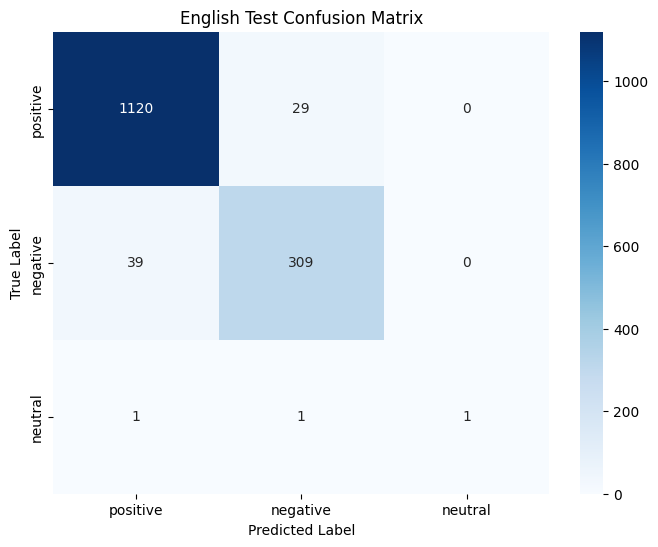


Pidgin Test (Cross-lingual) Detailed Metrics:
Accuracy: 0.4000
F1 Score (weighted): 0.4375
Precision (weighted): 0.6033
Recall (weighted): 0.4000

Classification Report:
              precision    recall  f1-score   support

    positive       0.14      0.76      0.24        78
    negative       0.79      0.46      0.59       469
     neutral       0.35      0.11      0.17       203

    accuracy                           0.40       750
   macro avg       0.43      0.44      0.33       750
weighted avg       0.60      0.40      0.44       750



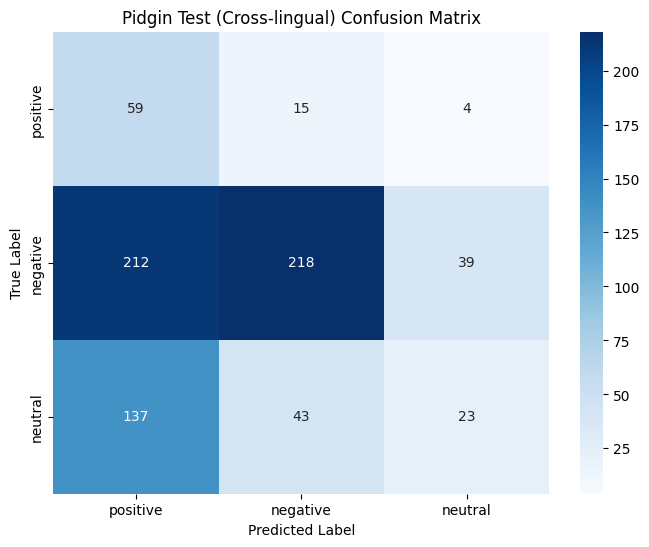

In [ ]:
# Print detailed metrics
print_detailed_metrics(english_preds, english_labels, "English Test")
print_detailed_metrics(pidgin_preds, pidgin_labels, "Pidgin Test (Cross-lingual)")


In [ ]:
# ## 10. Analyze Error Cases

# Function to analyze error cases
def analyze_errors(texts, preds, labels, dataset_name, max_examples=10):
    """Analyze and display error cases"""
    errors = []
    for i in range(len(texts)):
        if preds[i] != labels[i]:
            errors.append({
                'text': texts[i],
                'true_label': labels[i],
                'pred_label': preds[i]
            })

    print(f"\n{dataset_name} Error Analysis ({len(errors)} errors out of {len(texts)} samples):")
    print(f"Error rate: {len(errors)/len(texts):.2%}")

    # Group errors by type
    error_types = {}
    for error in errors:
        key = f"{error['true_label']} -> {error['pred_label']}"
        if key not in error_types:
            error_types[key] = []
        error_types[key].append(error)

    # Print error distribution
    print("\nError distribution:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]
        print(f"  {true_name} predicted as {pred_name}: {len(examples)} cases ({len(examples)/len(errors):.2%} of errors)")

    # Show examples of each error type
    print("\nExample errors by type:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]

        print(f"\n{true_name} predicted as {pred_name}:")
        for i, error in enumerate(examples[:max_examples]):
            print(f"  Example {i+1}: {error['text']}")

In [ ]:
# Analyze English errors
analyze_errors(
    english_test['cleaned_text'].tolist(),
    english_preds,
    english_labels,
    "English Test"
)


English Test Error Analysis (70 errors out of 1500 samples):
Error rate: 4.67%

Error distribution:
  negative predicted as positive: 39 cases (55.71% of errors)
  positive predicted as negative: 29 cases (41.43% of errors)
  neutral predicted as negative: 1 cases (1.43% of errors)
  neutral predicted as positive: 1 cases (1.43% of errors)

Example errors by type:

negative predicted as positive:
  Example 1: this is my go to coffee i love the flavor the price is reasonable for how many k cups you get definitely recommend it
  Example 2: very good ristretto but you only get a fraction out of your investment the way the capsules are designed the problem they do not allow to release the pressure at the right moment coffee comes out of the top and spills all over your dolce gusto coffee makers i have three different coffee makers and they don t work with any of them all original nes caf capsules work it s no problem be careful buying other than original
  Example 3: my poor husband is pa

In [ ]:
# Analyze Pidgin errors
analyze_errors(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_preds,
    pidgin_labels,
    "Pidgin Test"
)


Pidgin Test Error Analysis (450 errors out of 750 samples):
Error rate: 60.00%

Error distribution:
  neutral predicted as negative: 43 cases (9.56% of errors)
  negative predicted as neutral: 39 cases (8.67% of errors)
  neutral predicted as positive: 137 cases (30.44% of errors)
  negative predicted as positive: 212 cases (47.11% of errors)
  positive predicted as negative: 15 cases (3.33% of errors)
  positive predicted as neutral: 4 cases (0.89% of errors)

Example errors by type:

neutral predicted as negative:
  Example 1: all these thingsna on top radio we dey hear am we nor kuku dey see amabi na niger Niger i dey wey i dey hear nigeria Nigeria news EMOJI why is everything to help the poor under this administration audio while the one for the rich dey hit their account before it's even announced as token is buhari not better like this at least with him i saw people who benefited from npower tradermoni and school feeding till he handed it over to his gf niger ia which way
  Exam

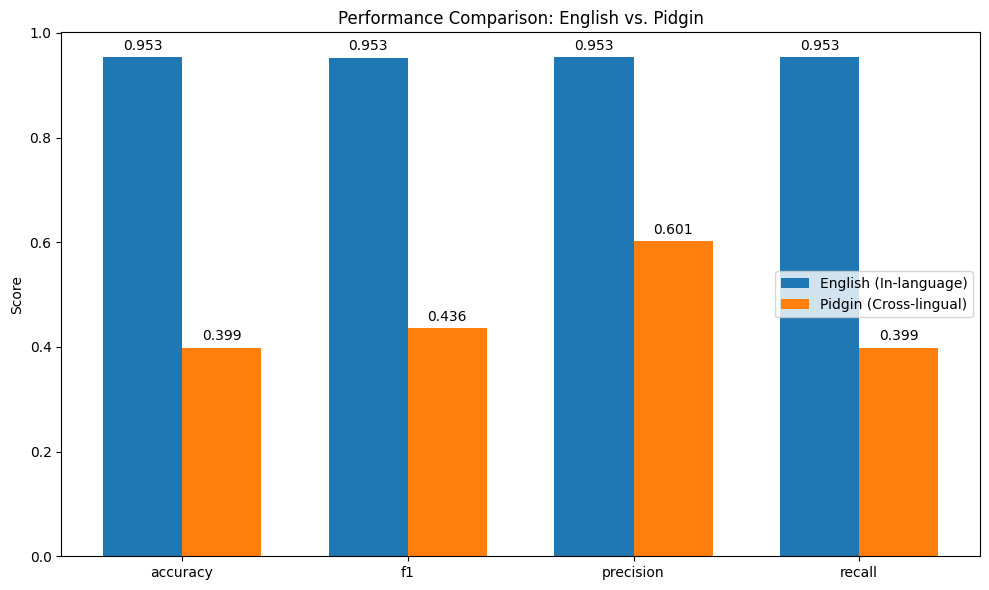

In [ ]:
# ## 11. Compare Performance Across Languages

# Plot comparison of in-language (English) vs cross-lingual (Pidgin) performance
def plot_performance_comparison(english_metrics, pidgin_metrics):
    """Plot performance comparison between languages"""
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    english_scores = [english_metrics[f'eval_{m}'] for m in metrics]
    pidgin_scores = [pidgin_metrics[f'eval_{m}'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, english_scores, width, label='English (In-language)')
    rects2 = ax.bar(x + width/2, pidgin_scores, width, label='Pidgin (Cross-lingual)')

    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison: English vs. Pidgin')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

# Plot performance comparison
plot_performance_comparison(english_test_results, pidgin_test_results)


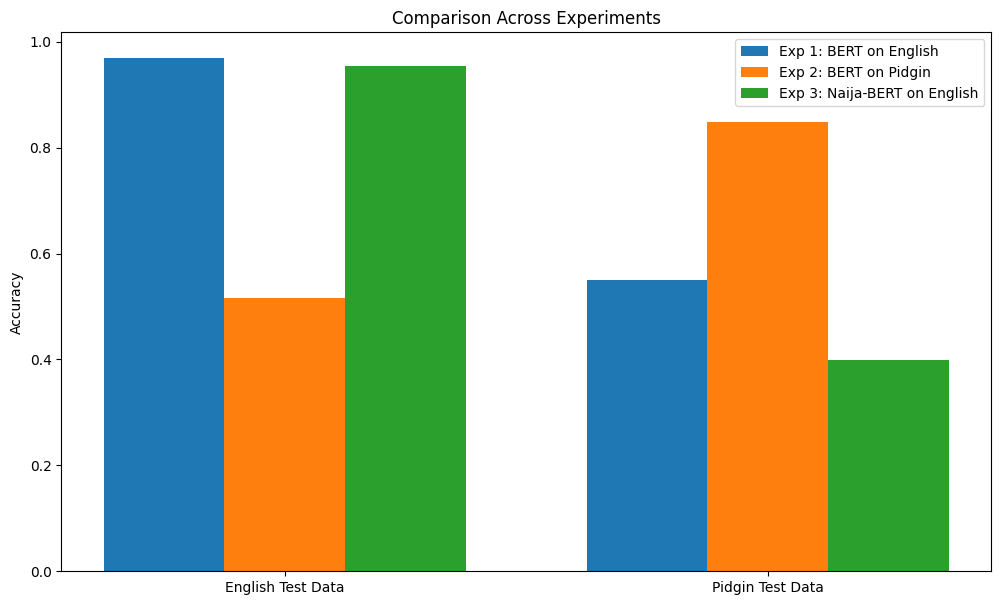

In [ ]:
# ## 12. Compare to Previous Experiments

# You can fill in the previous experiment results here to create a comparison
exp1_english_accuracy = 0.9693  # From Experiment 1 results
exp1_pidgin_accuracy = 0.5493   # From Experiment 1 results
exp2_english_accuracy = 0.516   # From Experiment 2 results
exp2_pidgin_accuracy = 0.848    # From Experiment 2 results
exp3_english_accuracy = english_test_results['eval_accuracy']
exp3_pidgin_accuracy = pidgin_test_results['eval_accuracy']

# Create comparison chart for all experiments
labels = ['English Test Data', 'Pidgin Test Data']
exp1_scores = [exp1_english_accuracy, exp1_pidgin_accuracy]
exp2_scores = [exp2_english_accuracy, exp2_pidgin_accuracy]
exp3_scores = [exp3_english_accuracy, exp3_pidgin_accuracy]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width, exp1_scores, width, label='Exp 1: BERT on English')
rects2 = ax.bar(x, exp2_scores, width, label='Exp 2: BERT on Pidgin')
rects3 = ax.bar(x + width, exp3_scores, width, label='Exp 3: Naija-BERT on English')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison Across Experiments')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()


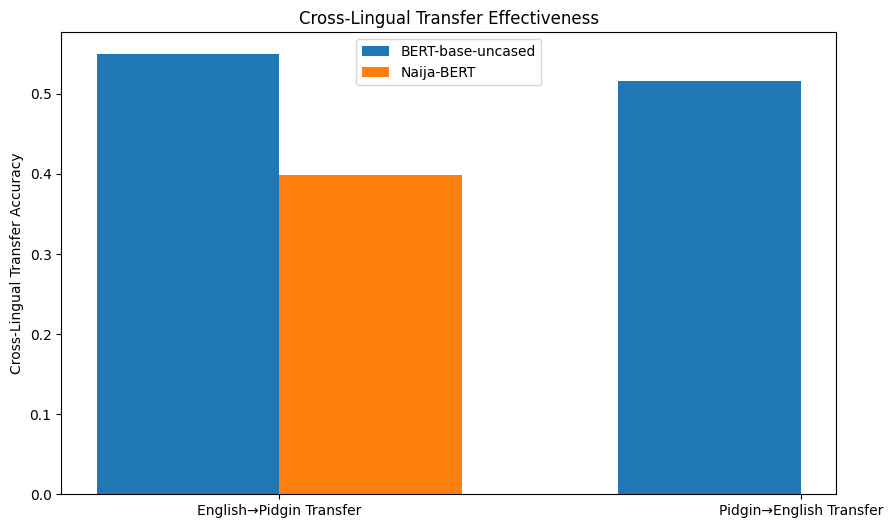

In [ ]:
# Cross-Lingual Transfer Analysis
transfer_labels = ['English→Pidgin Transfer', 'Pidgin→English Transfer']
transfer_exp1_exp2 = [exp1_pidgin_accuracy, exp2_english_accuracy]  # BERT
transfer_exp3 = [exp3_pidgin_accuracy, None]  # Naija-BERT (Exp 3 & future Exp 4)

x = np.arange(len(transfer_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, transfer_exp1_exp2, width, label='BERT-base-uncased')
rects2 = ax.bar(x + width/2, [transfer_exp3[0], float('nan')], width, label='Naija-BERT')

ax.set_ylabel('Cross-Lingual Transfer Accuracy')
ax.set_title('Cross-Lingual Transfer Effectiveness')
ax.set_xticks(x)
ax.set_xticklabels(transfer_labels)
ax.legend()

In [ ]:
# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        if not np.isnan(height):
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [ ]:
# ## 13. Save Results and Summary

# Create output directory if it doesn't exist
os.makedirs("./results/exp3", exist_ok=True)

# Save all results
results_summary = {
    'validation': val_results,
    'english_test': english_test_results,
    'pidgin_test': pidgin_test_results,
    'combined_test': combined_test_results
}


In [ ]:
# Write results to file
with open("./results/exp3/results_summary.txt", "w") as f:
    f.write("Experiment 3: Naija-BERT fine-tuned on English\n")
    f.write("=============================================\n\n")

    f.write("Model: Davlan/naija-bert-base with class weights\n")
    f.write(f"Train dataset size: {len(train_dataset)}\n")
    f.write(f"Validation dataset size: {len(val_dataset)}\n")
    f.write(f"English test dataset size: {len(english_test_dataset)}\n")
    f.write(f"Pidgin test dataset size: {len(pidgin_test_dataset)}\n")
    f.write(f"Combined test dataset size: {len(combined_test_dataset)}\n\n")

    f.write("Results:\n")
    for dataset_name, results in results_summary.items():
        f.write(f"\n{dataset_name.upper()} RESULTS:\n")
        for metric, value in results.items():
            f.write(f"  {metric}: {value}\n")

    # Compare with previous experiments
    f.write("\nCOMPARISON WITH PREVIOUS EXPERIMENTS:\n")
    f.write(f"  Exp1 (BERT on English) - English: {exp1_english_accuracy:.4f}, Pidgin: {exp1_pidgin_accuracy:.4f}\n")
    f.write(f"  Exp2 (BERT on Pidgin) - English: {exp2_english_accuracy:.4f}, Pidgin: {exp2_pidgin_accuracy:.4f}\n")
    f.write(f"  Exp3 (Naija-BERT on English) - English: {exp3_english_accuracy:.4f}, Pidgin: {exp3_pidgin_accuracy:.4f}\n")

print("\nExperiment completed! Results saved to ./results/exp3/results_summary.txt")



Experiment completed! Results saved to ./results/exp3/results_summary.txt
